# PCA, TSNE and UMAP plots are generated on filtered datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import utils_ML as uml
from sklearn.utils.class_weight import compute_class_weight

import sys
sys.path.append("../")
import utils_ML as uml


In [2]:
# Load datasets
data_combat = pd.read_csv("../preprocessing/combat_NSAF_50.csv", index_col = "assay_id")
data_quantile = pd.read_csv("../preprocessing/quantile_norm_NSAF_50.csv", index_col = "assay_id")
data_median_norm = pd.read_csv("../preprocessing/median_scaling_50.csv", index_col = "Unnamed: 0")
data_nsaf = pd.read_csv("../preprocessing/NSAF_50.csv", index_col = "assay_id")
data_nsaf = np.log2(data_nsaf)

data_columns = data_nsaf.columns

meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data_combat.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data_combat.sort_index(inplace=True)
data_quantile.sort_index(inplace=True)
data_median_norm.sort_index(inplace=True)
data_nsaf.sort_index(inplace=True)
meta.sort_index(inplace=True)

missing_value_mask = data_nsaf.isna()
data_combat = data_combat.where(~missing_value_mask, other=np.nan)

data_combat = data_combat.reset_index(drop=True).rename(columns={data_combat.columns[x]:x for x in range(len(data_combat.columns))})
data_quantile = data_quantile.reset_index(drop=True).rename(columns={data_quantile.columns[x]:x for x in range(len(data_quantile.columns))})
data_median_norm = data_median_norm.reset_index(drop=True).rename(columns={data_median_norm.columns[x]:x for x in range(len(data_median_norm.columns))})
data_nsaf = data_nsaf.reset_index(drop=True).rename(columns={data_nsaf.columns[x]:x for x in range(len(data_nsaf.columns))})

In [3]:
target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


In [10]:
mm_nsaf = pd.DataFrame(MinMaxScaler().fit_transform(data_nsaf)).fillna(0)
mm_quant = pd.DataFrame(MinMaxScaler().fit_transform(data_quantile)).fillna(0)
mm_median_norm = pd.DataFrame(MinMaxScaler().fit_transform(data_median_norm)).fillna(0)
mm_combat = pd.DataFrame(MinMaxScaler().fit_transform(data_combat)).fillna(0)

In [9]:
colors_pxd = sns.color_palette("bright")+sns.color_palette("pastel") + sns.color_palette("tab10") + sns.color_palette('dark') + sns.color_palette('colorblind')
colors_pxd = colors_pxd[:43]

In [4]:
data_nsaf_imputed = uml.LowestValueImputerGaussian().fit_transform(data_nsaf)

In [5]:
data_nsaf_imputed = MinMaxScaler().fit_transform(data_nsaf_imputed)

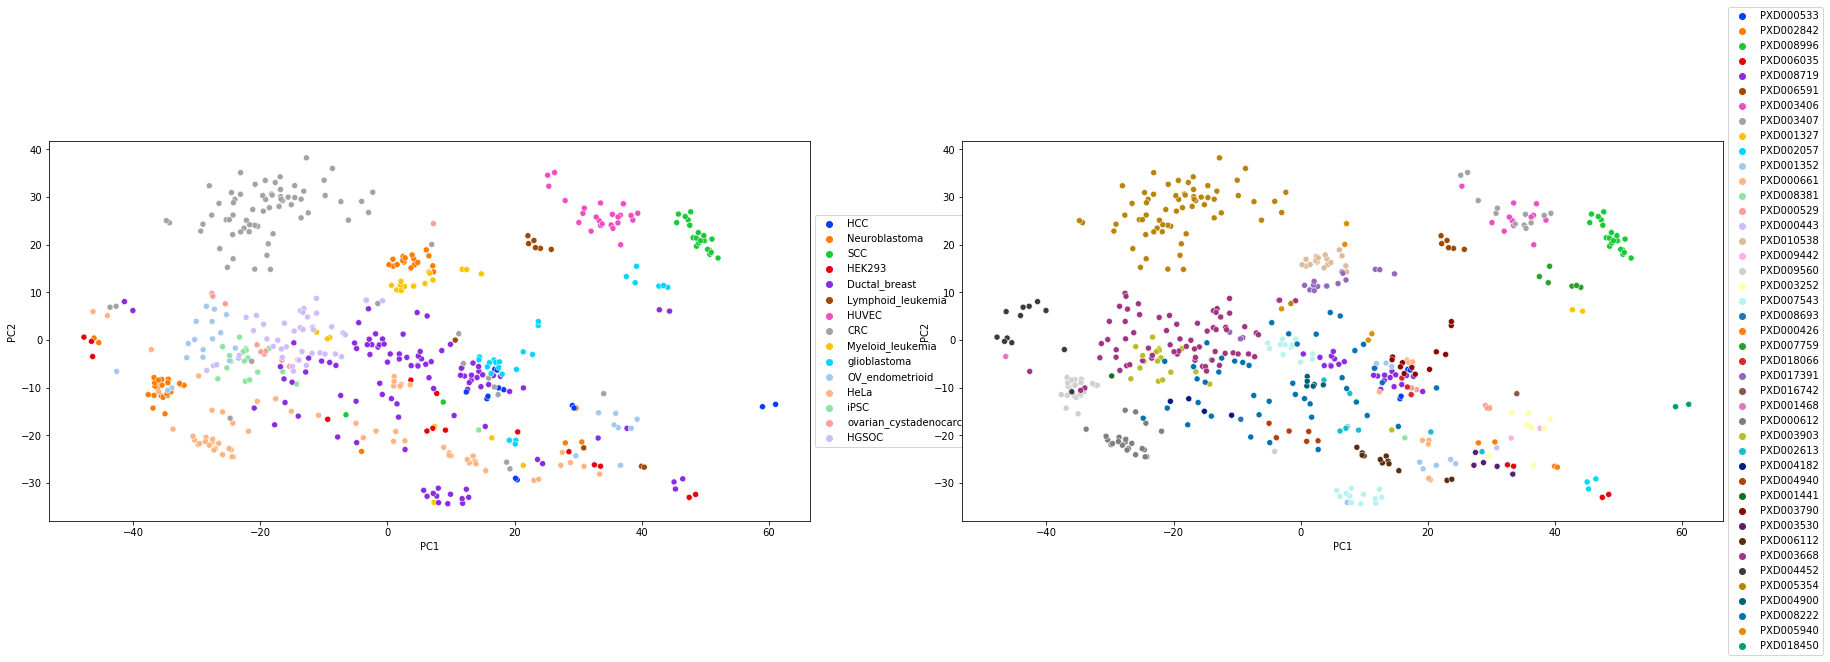

In [10]:
pca = PCA(n_components=2)

embedding = pca.fit_transform(data_nsaf_imputed)
fig, ax=plt.subplots(1,2,figsize=(30,7))
g=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta.reset_index()["Group"], palette = colors,ax=ax[0])
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

f=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta.reset_index()["PXD_accession"], palette = colors_pxd,ax=ax[1])
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))

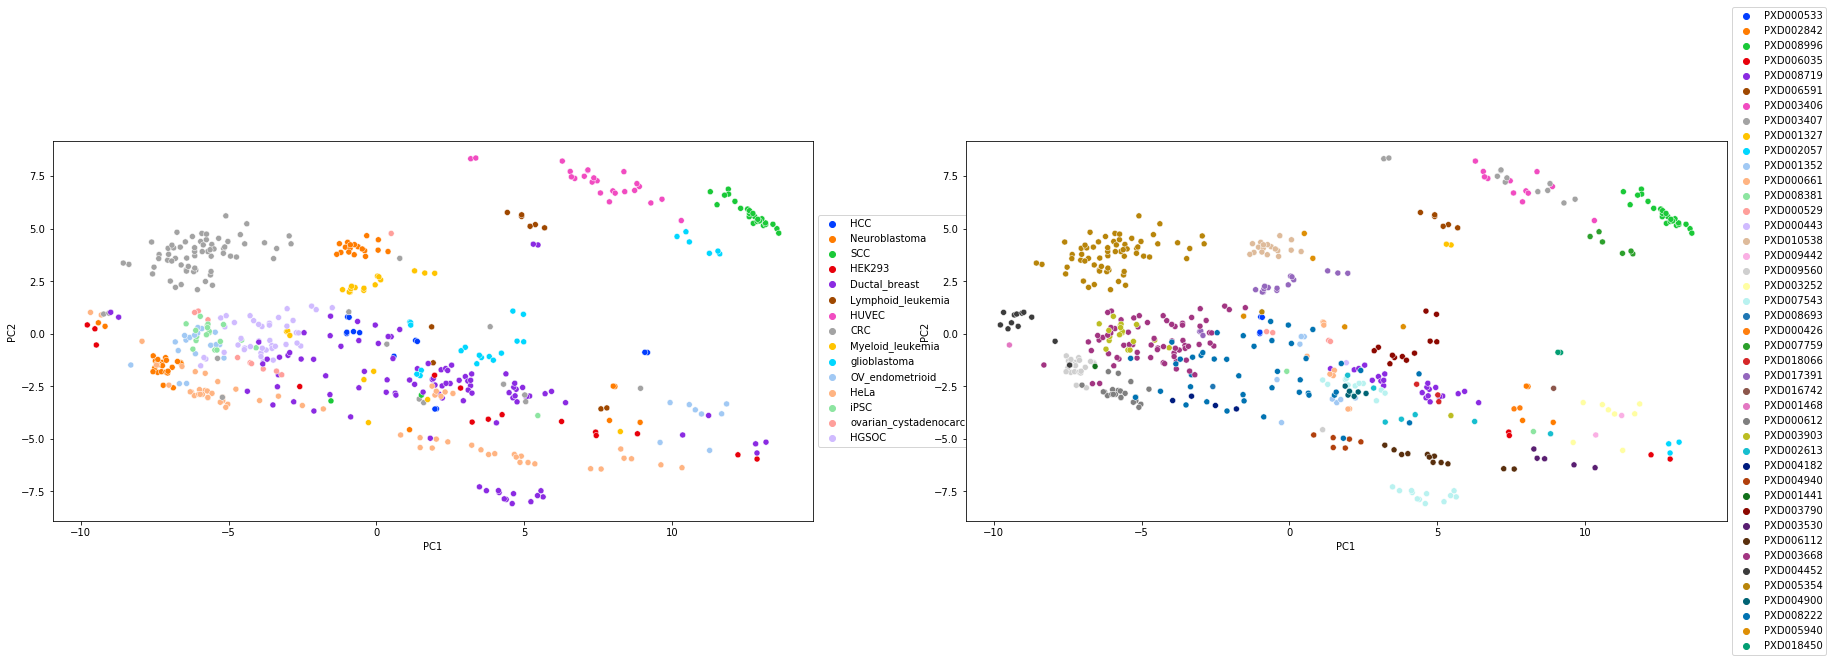

In [29]:
pca = PCA(n_components=2)

embedding = pca.fit_transform(mm_nsaf)
fig, ax=plt.subplots(1,2,figsize=(30,7))
g=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta.reset_index()["Group"], palette = colors,ax=ax[0])
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

f=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta.reset_index()["PXD_accession"], palette = colors_pxd,ax=ax[1])
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


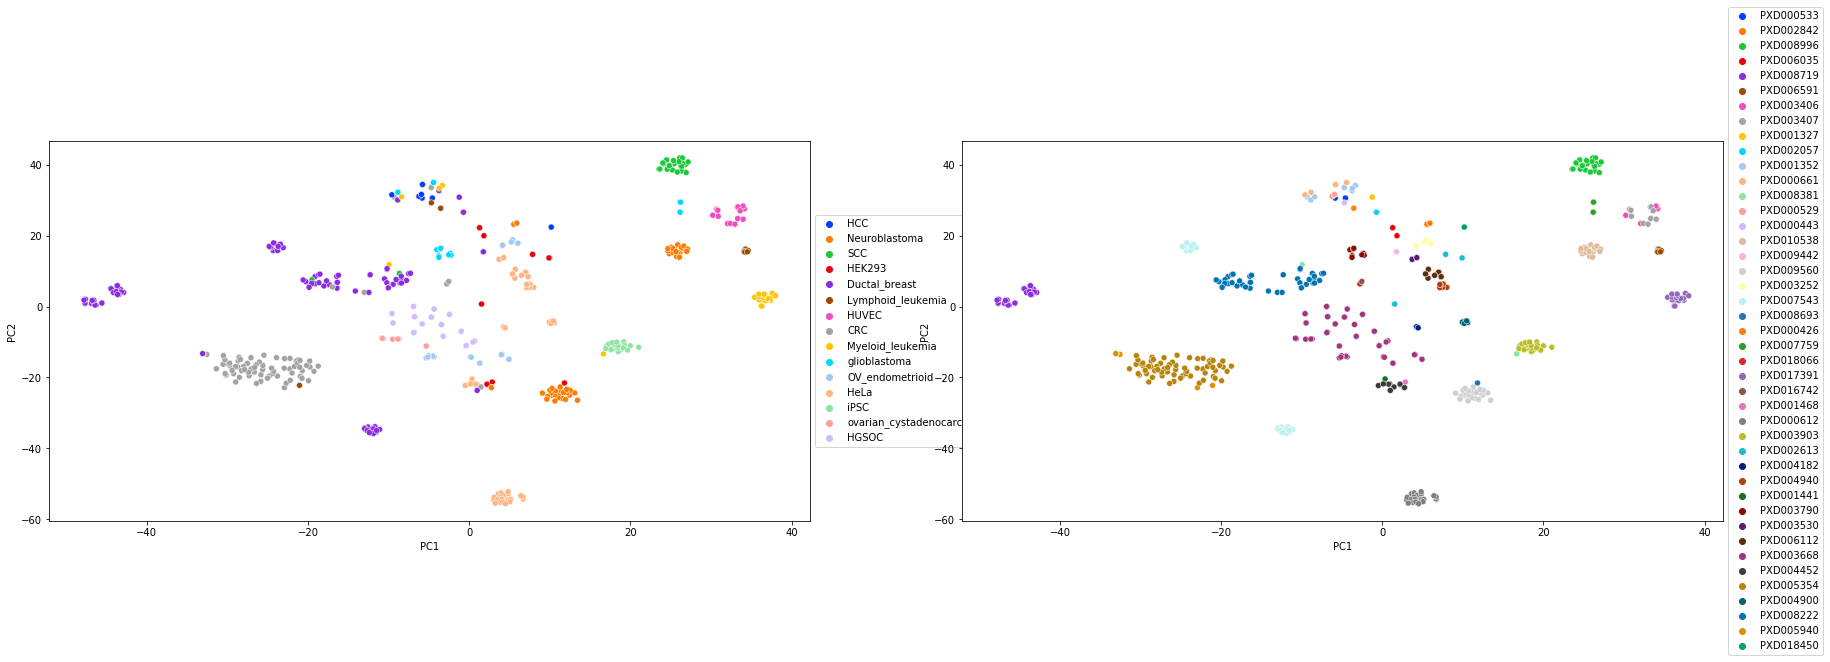

In [10]:
pca = TSNE(perplexity=20)

embedding = pca.fit_transform(data_nsaf_imputed)
fig, ax=plt.subplots(1,2,figsize=(30,7))
g=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta.reset_index()["Group"], palette = colors,ax=ax[0])
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

f=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta.reset_index()["PXD_accession"], palette = colors_pxd,ax=ax[1])
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 1.0, 'Ductal Breast cell lines')

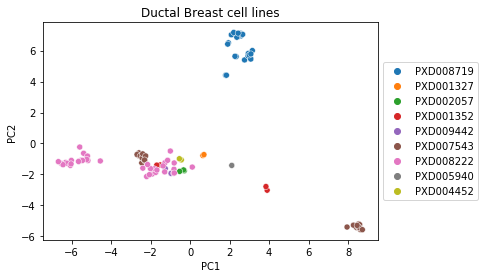

In [36]:
pca = PCA(n_components=2)

embedding = pca.fit_transform(data_nsaf_imputed[meta.reset_index().Group=="Ductal_breast"])
f=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta[meta.Group == "Ductal_breast"].reset_index()["PXD_accession"])
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Ductal Breast cell lines")

Text(0.5, 1.0, 'HeLa')

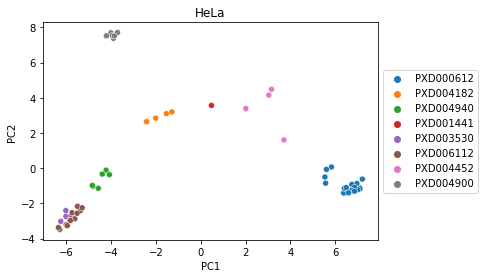

In [37]:
pca = PCA(n_components=2)

embedding = pca.fit_transform(data_nsaf_imputed[meta.reset_index().Group=="HeLa"])
f=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta[meta.Group == "HeLa"].reset_index()["PXD_accession"])
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("HeLa")

In [26]:
meta.Group.unique()

array(['HCC', 'Neuroblastoma', 'SCC', 'HEK293', 'Ductal_breast',
       'Lymphoid_leukemia', 'HUVEC', 'CRC', 'Myeloid_leukemia',
       'glioblastoma', 'OV_endometrioid', 'HeLa', 'iPSC',
       'ovarian_cystadenocarcinoma', 'HGSOC'], dtype=object)

Text(0.5, 1.0, 'HEK293')

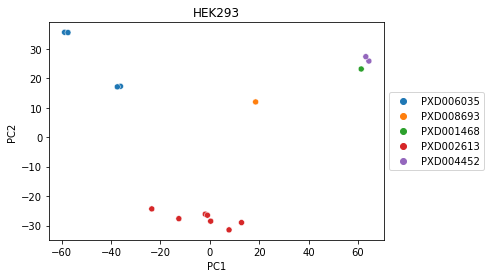

In [28]:
pca = PCA(n_components=2)

embedding = pca.fit_transform(data_nsaf_imputed[meta.reset_index().Group=="HEK293"])
f=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta[meta.Group == "HEK293"].reset_index()["PXD_accession"])
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("HEK293")

Text(0.5, 1.0, 'HEK293')

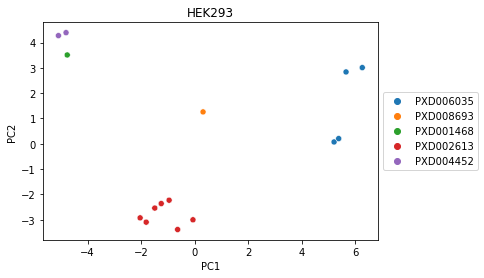

In [50]:
pca = PCA(n_components=2)

embedding = pca.fit_transform(minmax_df_combat[meta.reset_index().Group=="HEK293"])
f=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta[meta.Group == "HEK293"].reset_index()["PXD_accession"])
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("HEK293")

Text(0.5, 1.0, 'HeLa')

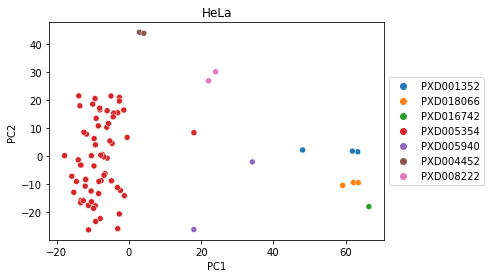

In [29]:
pca = PCA(n_components=2)

embedding = pca.fit_transform(data_nsaf_imputed[meta.reset_index().Group=="CRC"])
f=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta[meta.Group == "CRC"].reset_index()["PXD_accession"])
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("HeLa")

In [30]:
labels = np.array(meta.Group)
mmi_quant = uml.MNAR_MCAR_Imputer(max_iter=15)
mmi_combat = uml.MNAR_MCAR_Imputer(max_iter=15)
mmi_med = uml.MNAR_MCAR_Imputer(max_iter=15)
mmi_nsaf = uml.MNAR_MCAR_Imputer(max_iter=15)

mmi_quant.fit(data_quantile, labels)
mmi_combat.fit(data_combat, labels)
mmi_med.fit(data_median_norm, labels)
mmi_nsaf.fit(data_nsaf, labels)

imputed_df_quant = mmi_quant.transform(data_quantile, labels)
imputed_df_combat = mmi_combat.transform(data_combat, labels)
imputed_df_med = mmi_med.transform(data_median_norm, labels)
imputed_df_nsaf = mmi_nsaf.transform(data_nsaf, labels)

mm_scaler = MinMaxScaler()
minmax_df_quant = mm_scaler.fit_transform(imputed_df_quant)
minmax_df_combat = mm_scaler.fit_transform(imputed_df_combat)
minmax_df_med = mm_scaler.fit_transform(imputed_df_med)
minmax_df_nsaf = mm_scaler.fit_transform(imputed_df_nsaf)

First iteration: 0
iteration: 0
Components: 317
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 357
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 331
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 326
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14


In [31]:
minmax_df_quant = pd.DataFrame(minmax_df_quant, columns = data_columns)
minmax_df_combat = pd.DataFrame(minmax_df_combat, columns = data_columns)
minmax_df_med = pd.DataFrame(minmax_df_med, columns = data_columns)
minmax_df_nsaf = pd.DataFrame(minmax_df_nsaf, columns = data_columns)

In [7]:
colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

Text(0.5, 1.0, 'HeLa')

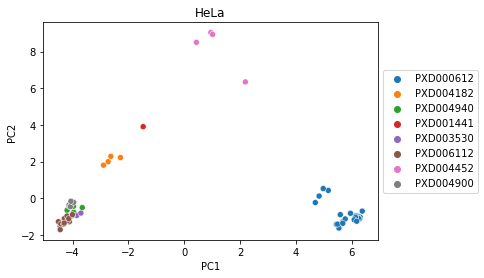

In [43]:
pca = PCA(n_components=2)

embedding = pca.fit_transform(minmax_df_quant[meta.reset_index().Group=="HeLa"])
f=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta[meta.Group == "HeLa"].reset_index()["PXD_accession"])
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("HeLa")

Text(0.5, 1.0, 'Ductal Breast cell lines')

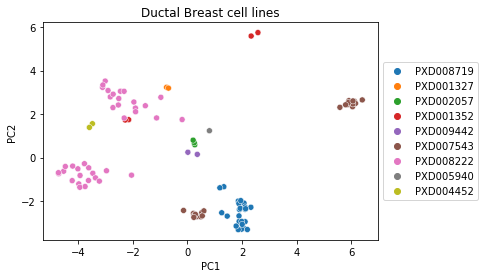

In [33]:
pca = PCA(n_components=2)

embedding = pca.fit_transform(minmax_df_quant[meta.reset_index().Group=="Ductal_breast"])
f=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta[meta.Group == "Ductal_breast"].reset_index()["PXD_accession"])
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Ductal Breast cell lines")

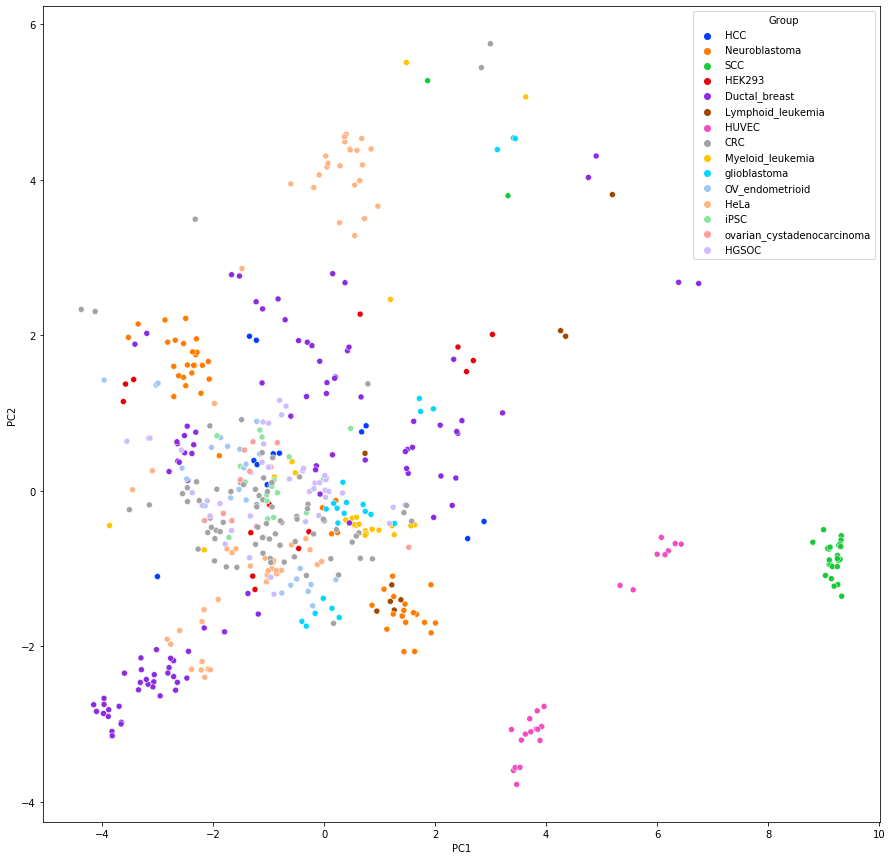

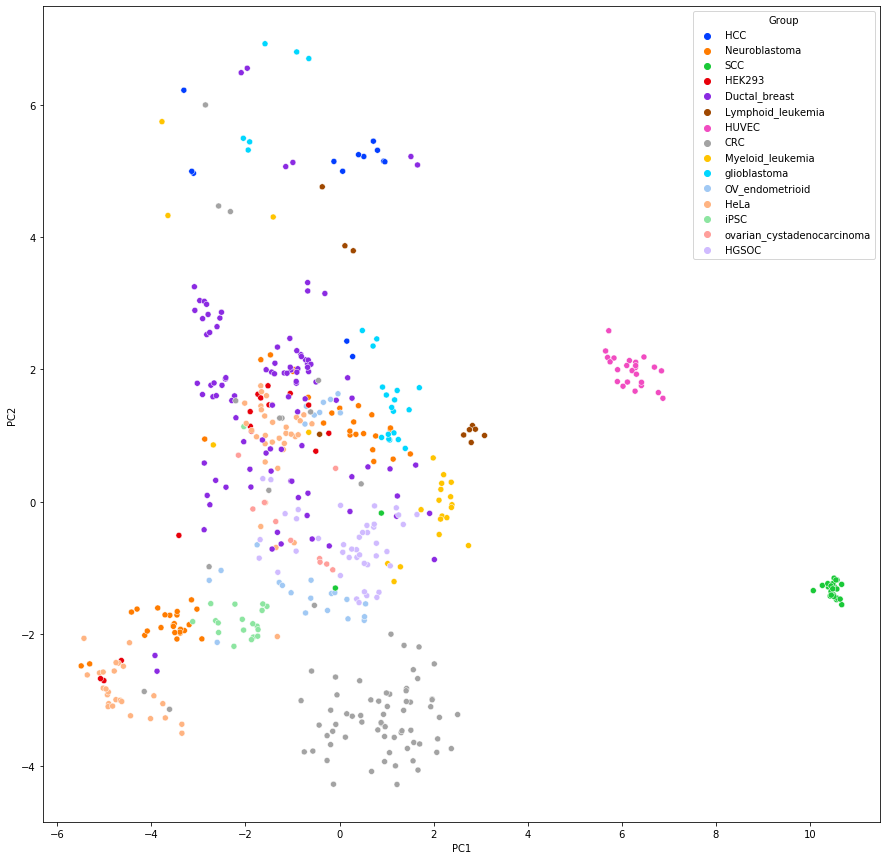

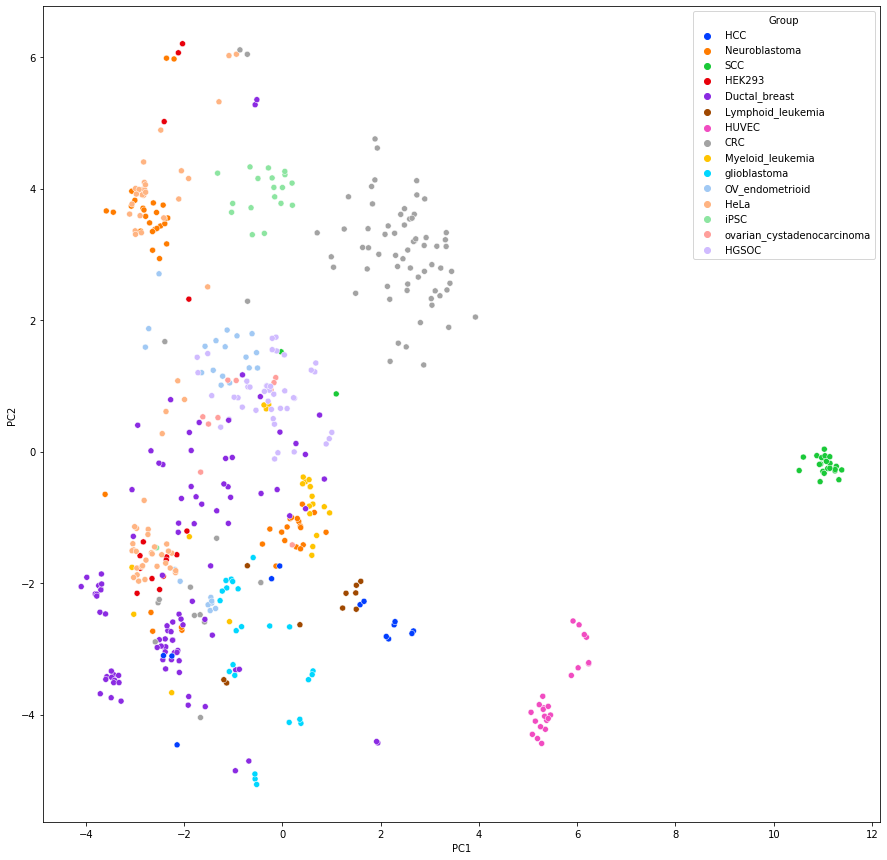

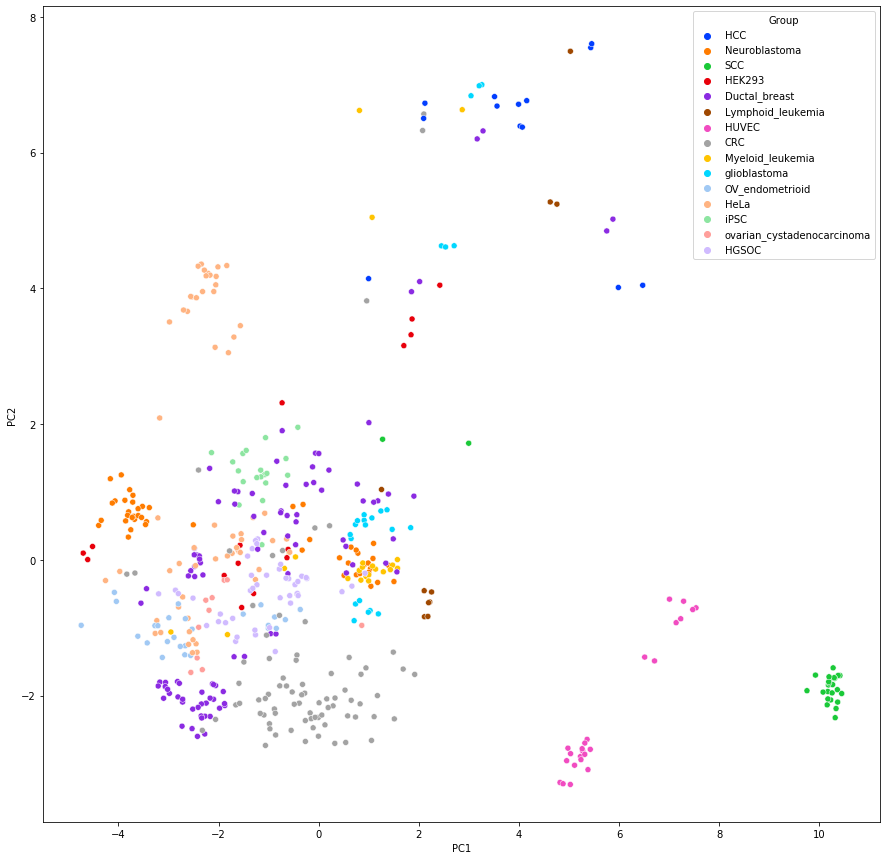

In [9]:
for dataset in [minmax_df_combat, minmax_df_med, minmax_df_quant, minmax_df_nsaf]:

    pca = PCA(n_components=2)

    embedding = pca.fit_transform(dataset)
    plt.figure(figsize=(5,5))
    g=sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta.reset_index()["Group"], palette = colors)
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

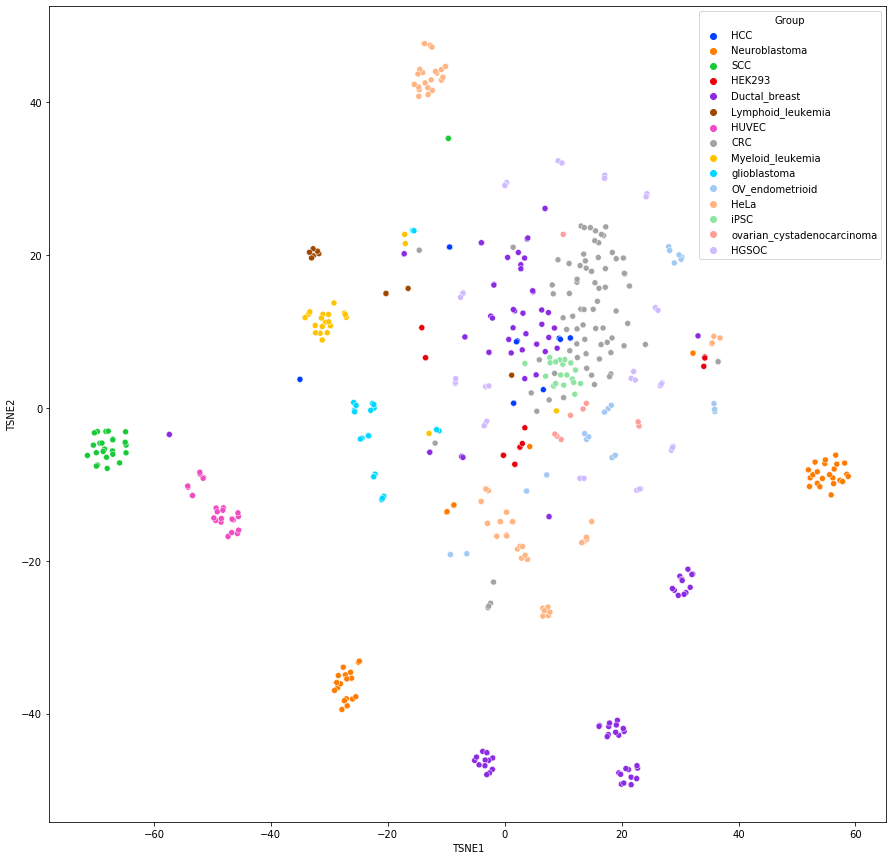

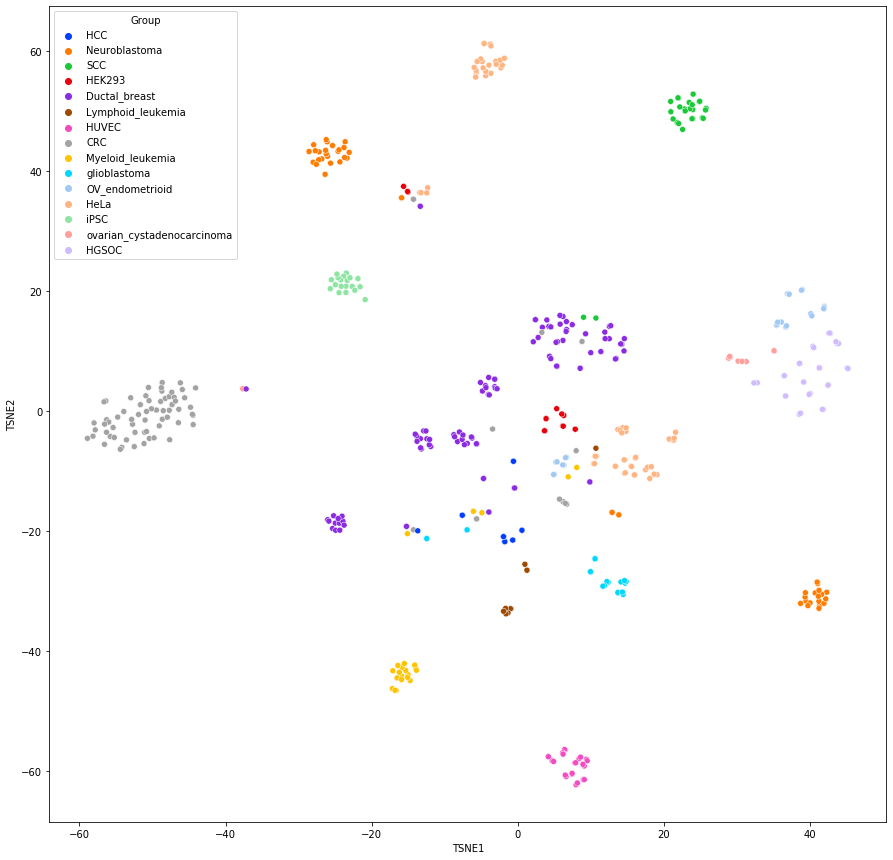

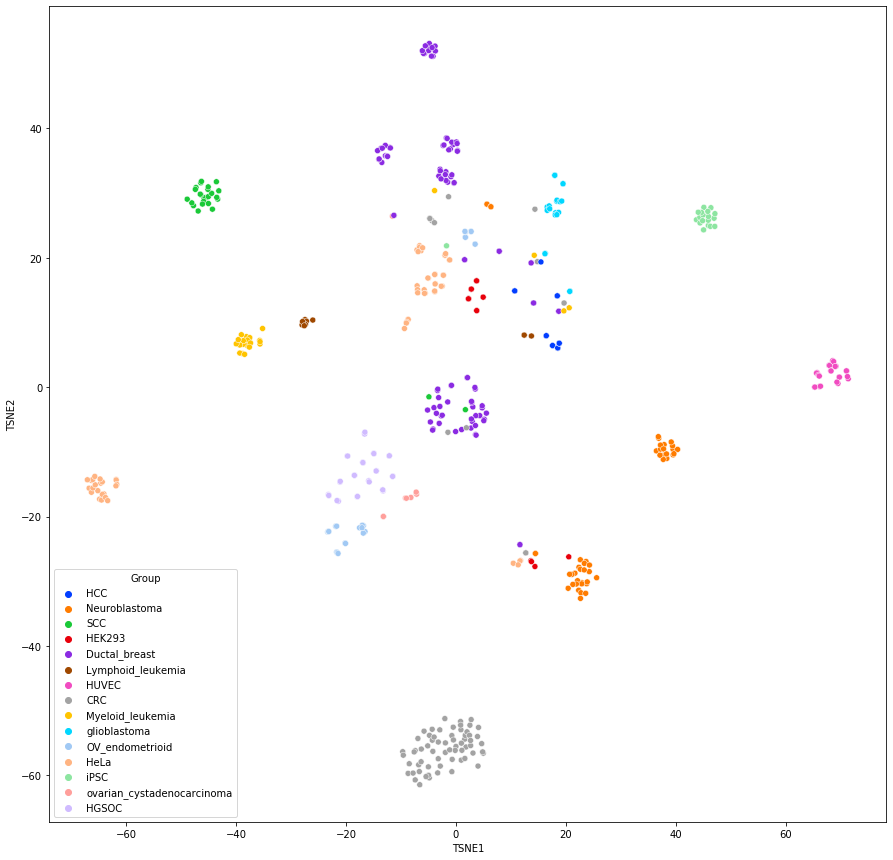

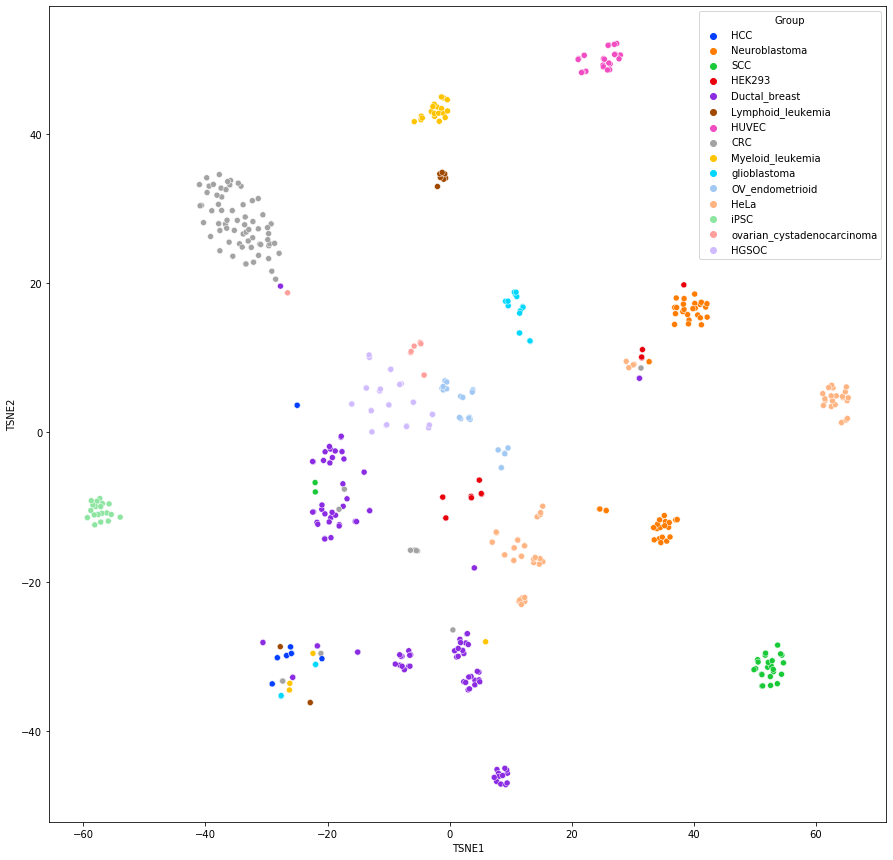

In [10]:
for dataset in [minmax_df_combat, minmax_df_med, minmax_df_quant, minmax_df_nsaf]:

    tsne = TSNE(perplexity=15)

    embedding = tsne.fit_transform(dataset)
    plt.figure(figsize=(15,15))
    sns.scatterplot(data=pd.DataFrame(embedding, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["Group"], palette = colors)

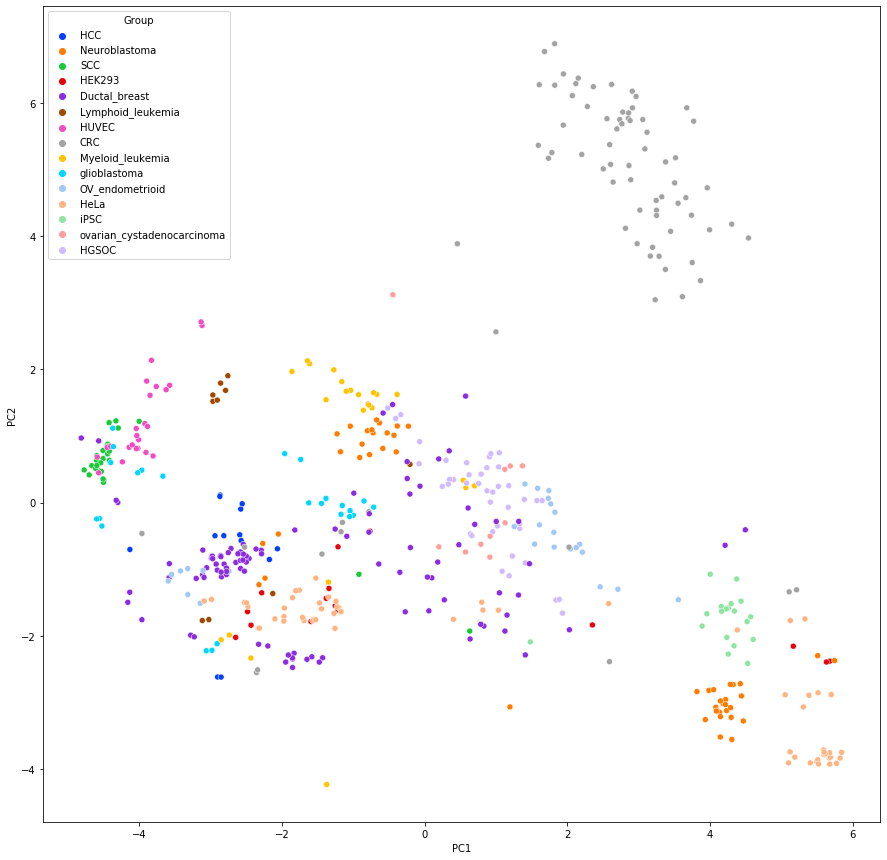

In [ ]:
pca = PCA(n_components=2)

embedding = pca.fit_transform(processed_data)
plt.figure(figsize=(15,15))
sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta.reset_index()["Group"], palette = colors)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


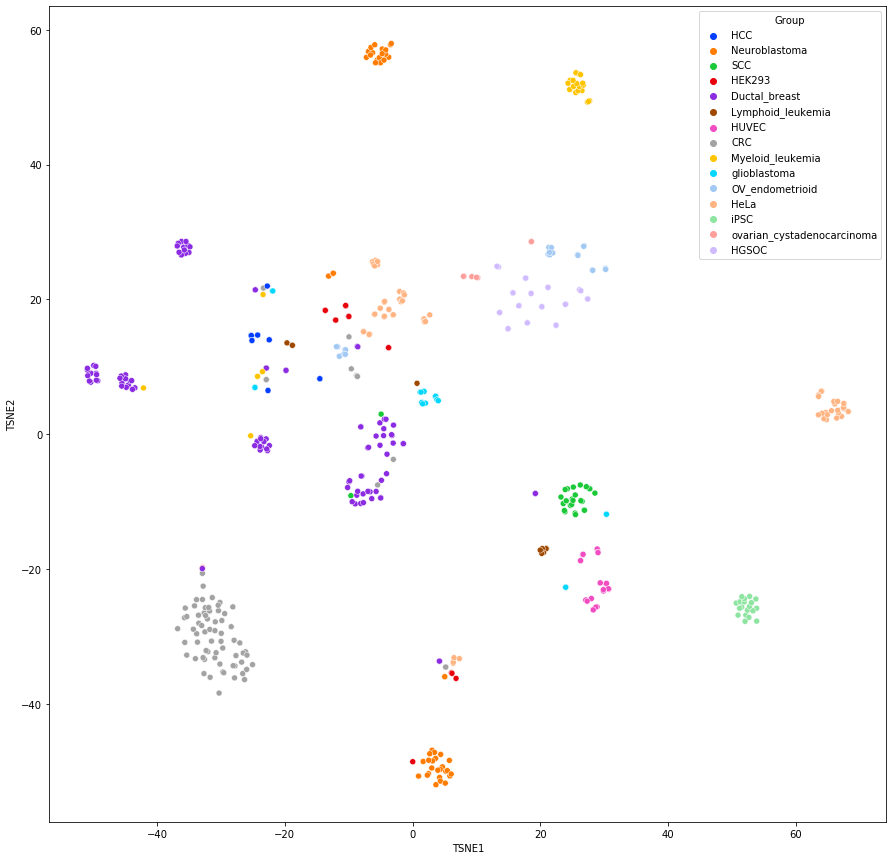

In [ ]:
tsne = TSNE(perplexity=15)

embedding = tsne.fit_transform(processed_data)
plt.figure(figsize=(15,15))
sns.scatterplot(data=pd.DataFrame(embedding, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["Group"], palette = colors)